In [34]:
import torch
import torch.nn.functional as F
from torch.utils import data
from torchinfo import summary
import torch.nn as nn
import torch.optim as optim
import sys
import pandas as pd
import pickle
import numpy as np
from tqdm import tqdm
from datetime import datetime
import copy
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report

In [2]:
import platform; print(platform.platform())

macOS-14.6-arm64-arm-64bit


In [3]:
def prepare_x(data):
    df1 = data[:40, :].T
    return np.array(df1)

def get_label(data):
    lob = data[-5:, :].T
    return lob

def data_classification(X, Y, T):
    [N, D] = X.shape
    # print(X.shape,T,N,Y.shape)
    df = np.array(X)
    print(df.shape)
    dY = np.array(Y)

    dataY = dY[T - 1:N]

    dataX = np.zeros((N - T + 1, T, D))
    for i in range(T, N + 1):
        dataX[i - T] = df[i - T:i, :]

    return dataX, dataY

def torch_data(x, y):
    x = torch.from_numpy(x)
    x = torch.unsqueeze(x, 1)
    y = torch.from_numpy(y)
    y = F.one_hot(y, num_classes=3)
    return x, y

In [4]:
class Dataset(data.Dataset):
    """Characterizes a dataset for PyTorch"""
    def __init__(self, data, k, num_classes, T):
        """Initialization""" 
        self.k = k
        self.num_classes = num_classes
        self.T = T
            
        x = prepare_x(data)
        y = get_label(data)
        x, y = data_classification(x, y, self.T)
        y = y[:,self.k] - 1
        self.length = len(x)

        x = torch.from_numpy(x)
        self.x = torch.unsqueeze(x, 1)
        self.y = torch.from_numpy(y)

    def __len__(self):
        """Denotes the total number of samples"""
        return self.length

    def __getitem__(self, index):
        """Generates samples of data"""
        return self.x[index], self.y[index]

In [5]:
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [6]:
device = mps_device

In [7]:
x.type()

'torch.mps.FloatTensor'

In [8]:
# please change the data_path to your local path
# data_path = '/nfs/home/zihaoz/limit_order_book/data'

dec_data = np.loadtxt('/Users/jandh/Downloads/data (1)/Train_Dst_NoAuction_DecPre_CF_7.txt')
dec_train = dec_data[:, :int(np.floor(dec_data.shape[1] * 0.8))]
dec_val = dec_data[:, int(np.floor(dec_data.shape[1] * 0.8)):]

dec_test1 = np.loadtxt('/Users/jandh/Downloads/data (1)/Test_Dst_NoAuction_DecPre_CF_8.txt')
dec_test2 = np.loadtxt('/Users/jandh/Downloads/data (1)/Test_Dst_NoAuction_DecPre_CF_8.txt')
dec_test3 = np.loadtxt('/Users/jandh/Downloads/data (1)/Test_Dst_NoAuction_DecPre_CF_8.txt')
dec_test = np.hstack((dec_test1, dec_test2, dec_test3))

print(dec_train.shape, dec_val.shape, dec_test.shape)

(149, 203800) (149, 50950) (149, 156516)


In [9]:
sys.getsizeof(dec_data)/1000000

303.662128

In [10]:
batch_size = 64

dataset_train = Dataset(data=dec_train, k=4, num_classes=3, T=100)
dataset_val = Dataset(data=dec_val, k=4, num_classes=3, T=100)
dataset_test = Dataset(data=dec_test, k=4, num_classes=3, T=100)

train_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=False)

print(dataset_train.x.shape, dataset_train.y.shape)

(203800, 40)
(50950, 40)
(156516, 40)
torch.Size([203701, 1, 100, 40]) torch.Size([203701])


In [11]:
tmp_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=1, shuffle=True)

for x, y in tmp_loader:
    print(x)
    print(y)
    print(x.shape, y.shape)
    break

tensor([[[[0.1276, 0.0100, 0.1274,  ..., 0.0150, 0.1265, 0.0332],
          [0.1276, 0.0100, 0.1274,  ..., 0.0150, 0.1265, 0.0332],
          [0.1276, 0.0100, 0.1274,  ..., 0.0150, 0.1265, 0.0332],
          ...,
          [0.1272, 0.0052, 0.1270,  ..., 0.0146, 0.1261, 0.0464],
          [0.1272, 0.0052, 0.1270,  ..., 0.0146, 0.1261, 0.0464],
          [0.1272, 0.0052, 0.1271,  ..., 0.0146, 0.1262, 0.0025]]]],
       dtype=torch.float64)
tensor([0.], dtype=torch.float64)
torch.Size([1, 1, 100, 40]) torch.Size([1])


In [12]:
# #CPU version
# class deeplob(nn.Module):
#     def __init__(self, y_len):
#         super().__init__()
#         self.y_len = y_len
        
#         # convolution blocks
#         self.conv1 = nn.Sequential(
#             nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(1,2), stride=(1,2)),
#             nn.LeakyReLU(negative_slope=0.01),
# #             nn.Tanh(),
#             nn.BatchNorm2d(32),
#             nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
#             nn.LeakyReLU(negative_slope=0.01),
#             nn.BatchNorm2d(32),
#             nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
#             nn.LeakyReLU(negative_slope=0.01),
#             nn.BatchNorm2d(32),
#         )
#         self.conv2 = nn.Sequential(
#             nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1,2), stride=(1,2)),
#             nn.Tanh(),
#             nn.BatchNorm2d(32),
#             nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
#             nn.Tanh(),
#             nn.BatchNorm2d(32),
#             nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
#             nn.Tanh(),
#             nn.BatchNorm2d(32),
#         )
#         self.conv3 = nn.Sequential(
#             nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1,10)),
#             nn.LeakyReLU(negative_slope=0.01),
#             nn.BatchNorm2d(32),
#             nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
#             nn.LeakyReLU(negative_slope=0.01),
#             nn.BatchNorm2d(32),
#             nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
#             nn.LeakyReLU(negative_slope=0.01),
#             nn.BatchNorm2d(32),
#         )
        
#         # inception moduels
#         self.inp1 = nn.Sequential(
#             nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1,1), padding='same'),
#             nn.LeakyReLU(negative_slope=0.01),
#             nn.BatchNorm2d(64),
#             nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,1), padding='same'),
#             nn.LeakyReLU(negative_slope=0.01),
#             nn.BatchNorm2d(64),
#         )
#         self.inp2 = nn.Sequential(
#             nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1,1), padding='same'),
#             nn.LeakyReLU(negative_slope=0.01),
#             nn.BatchNorm2d(64),
#             nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(5,1), padding='same'),
#             nn.LeakyReLU(negative_slope=0.01),
#             nn.BatchNorm2d(64),
#         )
#         self.inp3 = nn.Sequential(
#             nn.MaxPool2d((3, 1), stride=(1, 1), padding=(1, 0)),
#             nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1,1), padding='same'),
#             nn.LeakyReLU(negative_slope=0.01),
#             nn.BatchNorm2d(64),
#         )
        
#         # lstm layers
#         self.lstm = nn.LSTM(input_size=192, hidden_size=64, num_layers=1, batch_first=True)
#         self.fc1 = nn.Linear(64, self.y_len)

#     def forward(self, x):
#         # h0: (number of hidden layers, batch size, hidden size)
#         h0 = torch.zeros(1, x.size(0), 64).to(device)
#         c0 = torch.zeros(1, x.size(0), 64).to(device)
    
#         x = self.conv1(x)
#         x = self.conv2(x)
#         x = self.conv3(x)
        
#         x_inp1 = self.inp1(x)
#         x_inp2 = self.inp2(x)
#         x_inp3 = self.inp3(x)  
        
#         x = torch.cat((x_inp1, x_inp2, x_inp3), dim=1)
        
# #         x = torch.transpose(x, 1, 2)
#         x = x.permute(0, 2, 1, 3)
#         x = torch.reshape(x, (-1, x.shape[1], x.shape[2]))
        
#         x, _ = self.lstm(x, (h0, c0))
#         x = x[:, -1, :]
#         x = self.fc1(x)
#         forecast_y = torch.softmax(x, dim=1)
        
#         return forecast_y

In [13]:
class deeplob(nn.Module):
    def __init__(self, y_len):
        super().__init__()
        self.y_len = y_len
        
        # convolution blocks
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(1,2), stride=(1,2)),
            nn.LeakyReLU(negative_slope=0.01),
#             nn.Tanh(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1,2), stride=(1,2)),
            nn.Tanh(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.Tanh(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.Tanh(),
            nn.BatchNorm2d(32),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1,10)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
        )
        
        # inception moduels
        self.inp1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
        )
        self.inp2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(5,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
        )
        self.inp3 = nn.Sequential(
            nn.MaxPool2d((3, 1), stride=(1, 1), padding=(1, 0)),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
        )
        
        # lstm layers
        self.lstm = nn.LSTM(input_size=192, hidden_size=64, num_layers=1, batch_first=True)
        self.fc1 = nn.Linear(64, self.y_len)

    def forward(self, x):
        # h0: (number of hidden layers, batch size, hidden size)
        h0 = torch.zeros(1, x.size(0), 64).to(device)
        c0 = torch.zeros(1, x.size(0), 64).to(device)
    
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        
        x_inp1 = self.inp1(x)
        x_inp2 = self.inp2(x)
        x_inp3 = self.inp3(x)  
        
        x = torch.cat((x_inp1, x_inp2, x_inp3), dim=1)
        
#         x = torch.transpose(x, 1, 2)
        x = x.permute(0, 2, 1, 3).contiguous()
        x = torch.reshape(x, (-1, x.shape[1], x.shape[2]))
        
        x, _ = self.lstm(x, (h0, c0))
        x = x[:, -1, :]
        x = self.fc1(x)
        forecast_y = torch.softmax(x, dim=1)
        
        return forecast_y

In [14]:
# # testing gradiant flows for CPU and GPU

# model = deeplob(y_len = dataset_train.num_classes)
# model2 = deeplob(y_len = dataset_train.num_classes)
# model2.load_state_dict(model.state_dict())
# # print(torch.allclose(model.weight, model2.weight))

# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
# optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.0001)

# data_iter = iter(train_loader)
# inputs , targets = next(data_iter)
# device = 'cpu'
# # print(inputs)
#  # = train_loader.next()
# optimizer.zero_grad()
# outputs = model(inputs.to(torch.float))
# loss = criterion(outputs, targets.to(dtype=torch.int64))
# print(loss)
# loss.backward()
# optimizer.step()

# print(model.inp3[1].weight.grad.max())

# for name, param in model.lstm.named_parameters():
#     if 'weight' in name:
#         print(name, param.grad.max()) 

# for name, param in model2.lstm.named_parameters():
#     if 'weight' in name:
#         print(name, param.grad.max()) 

# print(model2.inp3[1].weight.grad.max())

# device = mps_device
# model2.to(mps_device)
# # inputs , targets = next(data_iter)
# optimizer2.zero_grad()
# outputs2 = model2(inputs.to(mps_device,dtype = torch.float32))
# loss2 = criterion(outputs2, targets.to(mps_device,dtype=torch.int64))
# print(loss2)
# loss2.backward()
# optimizer2.step()

# def compare_models(model_1, model_2):
#     models_differ = 0
#     for key_item_1, key_item_2 in zip(model_1.state_dict().items(), model_2.state_dict().items()):
#         if torch.equal(key_item_1[1], key_item_2[1]):
#             pass
#         else:
#             models_differ += 1
#             if (key_item_1[0] == key_item_2[0]):
#                 print('Mismtach found at', key_item_1[0])
#             else:
#                 raise Exception
#     if models_differ == 0:
#         print('Models match perfectly! :)')

In [15]:
model = deeplob(y_len = dataset_train.num_classes)
model.to(mps_device)
device = mps_device

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
state_dict = None

In [17]:
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):
    global state_dict
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    best_test_loss = np.inf
    best_test_epoch = 0

    for it in tqdm(range(epochs)):
        
        model.train()
        t0 = datetime.now()
        train_loss = []
        for inputs, targets in train_loader:
            # move data to GPU
            inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)
            # print("inputs.shape:", inputs.shape)
            # zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass
            # print("about to get model output")
            outputs = model(inputs)
            # print("done getting model output")
            # print("outputs.shape:", outputs.shape, "targets.shape:", targets.shape)
            loss = criterion(outputs, targets)
            # Backward and optimize
            # print("about to optimize")
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
        # Get train loss and test loss
        train_loss = np.mean(train_loss) # a little misleading
    
        model.eval()
        test_loss = []
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)      
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
        test_loss = np.mean(test_loss)

        # Save losses
        train_losses[it] = train_loss
        test_losses[it] = test_loss
        
        if test_loss < best_test_loss:
            # state_dict = copy.deepcopy(model.state_dict())
            torch.save(model, '/Users/jandh/Desktop/Old Desktop/od/1 quater/Project Lab/best_val_model_pytorch')
            best_test_loss = test_loss
            best_test_epoch = it
            print('model saved')

        dt = datetime.now() - t0
        print(dt)
        print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
          Validation Loss: {test_loss:.4f}, Duration: {dt}, Best Val Epoch: {best_test_epoch}')

    return train_losses, test_losses

In [18]:
# import multiprocessing
# multiprocessing.set_start_method("fork")

In [19]:
train_losses, val_losses = batch_gd(model, criterion, optimizer, 
                                    train_loader, val_loader, epochs=50)

  2%|▊                                        | 1/50 [02:59<2:26:29, 179.37s/it]

model saved
0:02:59.369835
Epoch 1/50, Train Loss: 0.9309,           Validation Loss: 1.0139, Duration: 0:02:59.369835, Best Val Epoch: 0


  4%|█▌                                     | 2/50 [36:13<16:37:24, 1246.76s/it]

model saved
0:33:13.927446
Epoch 2/50, Train Loss: 0.8378,           Validation Loss: 0.9866, Duration: 0:33:13.927446, Best Val Epoch: 1


  6%|██▎                                    | 3/50 [53:57<15:11:26, 1163.53s/it]

model saved
0:17:44.491916
Epoch 3/50, Train Loss: 0.8092,           Validation Loss: 0.9567, Duration: 0:17:44.491916, Best Val Epoch: 2


  8%|███▎                                     | 4/50 [55:44<9:32:16, 746.45s/it]

model saved
0:01:47.069941
Epoch 4/50, Train Loss: 0.7891,           Validation Loss: 0.9467, Duration: 0:01:47.069941, Best Val Epoch: 3


 10%|████                                     | 5/50 [58:05<6:36:00, 528.02s/it]

model saved
0:02:20.719337
Epoch 5/50, Train Loss: 0.7738,           Validation Loss: 0.9295, Duration: 0:02:20.719337, Best Val Epoch: 4


 12%|████▋                                  | 6/50 [1:00:45<4:55:19, 402.72s/it]

model saved
0:02:39.481361
Epoch 6/50, Train Loss: 0.7621,           Validation Loss: 0.9223, Duration: 0:02:39.481361, Best Val Epoch: 5


 14%|█████▍                                 | 7/50 [1:03:35<3:54:15, 326.87s/it]

model saved
0:02:50.703306
Epoch 7/50, Train Loss: 0.7522,           Validation Loss: 0.9095, Duration: 0:02:50.703306, Best Val Epoch: 6


 16%|██████▏                                | 8/50 [1:06:44<3:18:04, 282.97s/it]

0:03:08.966588
Epoch 8/50, Train Loss: 0.7429,           Validation Loss: 0.9180, Duration: 0:03:08.966588, Best Val Epoch: 6


 18%|███████                                | 9/50 [1:09:52<2:52:55, 253.05s/it]

0:03:07.268492
Epoch 9/50, Train Loss: 0.7353,           Validation Loss: 0.9176, Duration: 0:03:07.268492, Best Val Epoch: 6


 20%|███████▌                              | 10/50 [1:13:02<2:35:51, 233.79s/it]

model saved
0:03:10.651055
Epoch 10/50, Train Loss: 0.7285,           Validation Loss: 0.9077, Duration: 0:03:10.651055, Best Val Epoch: 9


 22%|████████▎                             | 11/50 [1:16:18<2:24:29, 222.28s/it]

model saved
0:03:16.199977
Epoch 11/50, Train Loss: 0.7228,           Validation Loss: 0.8969, Duration: 0:03:16.199977, Best Val Epoch: 10


 24%|█████████                             | 12/50 [1:19:32<2:15:10, 213.43s/it]

0:03:13.187558
Epoch 12/50, Train Loss: 0.7177,           Validation Loss: 0.8974, Duration: 0:03:13.187558, Best Val Epoch: 10


 26%|█████████▉                            | 13/50 [1:22:53<2:09:23, 209.81s/it]

0:03:21.478249
Epoch 13/50, Train Loss: 0.7130,           Validation Loss: 0.9038, Duration: 0:03:21.478249, Best Val Epoch: 10


 28%|██████████▋                           | 14/50 [1:26:10<2:03:38, 206.07s/it]

0:03:17.416703
Epoch 14/50, Train Loss: 0.7094,           Validation Loss: 0.9094, Duration: 0:03:17.416703, Best Val Epoch: 10


 30%|███████████▍                          | 15/50 [1:29:28<1:58:38, 203.38s/it]

0:03:17.145062
Epoch 15/50, Train Loss: 0.7050,           Validation Loss: 0.9089, Duration: 0:03:17.145062, Best Val Epoch: 10


 32%|████████████▏                         | 16/50 [1:32:48<1:54:48, 202.62s/it]

0:03:20.845745
Epoch 16/50, Train Loss: 0.7018,           Validation Loss: 0.8989, Duration: 0:03:20.845745, Best Val Epoch: 10


 34%|████████████▉                         | 17/50 [1:36:11<1:51:27, 202.64s/it]

0:03:22.678289
Epoch 17/50, Train Loss: 0.6987,           Validation Loss: 0.8983, Duration: 0:03:22.678289, Best Val Epoch: 10


 36%|█████████████▋                        | 18/50 [1:39:36<1:48:23, 203.22s/it]

model saved
0:03:24.581245
Epoch 18/50, Train Loss: 0.6959,           Validation Loss: 0.8954, Duration: 0:03:24.581245, Best Val Epoch: 17


 38%|██████████████▍                       | 19/50 [1:42:53<1:44:06, 201.50s/it]

0:03:17.492115
Epoch 19/50, Train Loss: 0.6936,           Validation Loss: 0.9140, Duration: 0:03:17.492115, Best Val Epoch: 17


 40%|███████████████▏                      | 20/50 [1:46:14<1:40:35, 201.18s/it]

0:03:20.443460
Epoch 20/50, Train Loss: 0.6911,           Validation Loss: 0.9070, Duration: 0:03:20.443460, Best Val Epoch: 17


 42%|███████████████▉                      | 21/50 [1:49:38<1:37:40, 202.07s/it]

0:03:24.131198
Epoch 21/50, Train Loss: 0.6880,           Validation Loss: 0.9047, Duration: 0:03:24.131198, Best Val Epoch: 17


 44%|████████████████▋                     | 22/50 [1:52:57<1:33:50, 201.08s/it]

0:03:18.767922
Epoch 22/50, Train Loss: 0.6859,           Validation Loss: 0.9009, Duration: 0:03:18.767922, Best Val Epoch: 17


 46%|█████████████████▍                    | 23/50 [1:56:21<1:30:55, 202.05s/it]

0:03:24.307255
Epoch 23/50, Train Loss: 0.6834,           Validation Loss: 0.9099, Duration: 0:03:24.307255, Best Val Epoch: 17


 48%|██████████████████▏                   | 24/50 [1:59:44<1:27:39, 202.30s/it]

0:03:22.896365
Epoch 24/50, Train Loss: 0.6812,           Validation Loss: 0.9082, Duration: 0:03:22.896365, Best Val Epoch: 17


 50%|███████████████████                   | 25/50 [2:03:03<1:23:51, 201.27s/it]

0:03:18.863766
Epoch 25/50, Train Loss: 0.6798,           Validation Loss: 0.9048, Duration: 0:03:18.863766, Best Val Epoch: 17


 52%|███████████████████▊                  | 26/50 [2:06:28<1:20:57, 202.40s/it]

0:03:25.033107
Epoch 26/50, Train Loss: 0.6786,           Validation Loss: 0.9094, Duration: 0:03:25.033107, Best Val Epoch: 17


 54%|████████████████████▌                 | 27/50 [2:14:49<1:51:59, 292.14s/it]

0:08:21.496058
Epoch 27/50, Train Loss: 0.6766,           Validation Loss: 0.9047, Duration: 0:08:21.496058, Best Val Epoch: 17


 56%|█████████████████████▎                | 28/50 [2:16:57<1:29:00, 242.77s/it]

0:02:07.572302
Epoch 28/50, Train Loss: 0.6751,           Validation Loss: 0.9125, Duration: 0:02:07.572302, Best Val Epoch: 17


 58%|██████████████████████                | 29/50 [2:20:15<1:20:19, 229.52s/it]

0:03:18.603223
Epoch 29/50, Train Loss: 0.6728,           Validation Loss: 0.9067, Duration: 0:03:18.603223, Best Val Epoch: 17


 60%|██████████████████████▊               | 30/50 [2:23:35<1:13:34, 220.70s/it]

0:03:20.135480
Epoch 30/50, Train Loss: 0.6714,           Validation Loss: 0.9054, Duration: 0:03:20.135480, Best Val Epoch: 17


 62%|███████████████████████▌              | 31/50 [2:26:48<1:07:14, 212.32s/it]

0:03:12.766508
Epoch 31/50, Train Loss: 0.6706,           Validation Loss: 0.9080, Duration: 0:03:12.766508, Best Val Epoch: 17


 64%|████████████████████████▎             | 32/50 [2:30:02<1:02:02, 206.78s/it]

0:03:13.838944
Epoch 32/50, Train Loss: 0.6693,           Validation Loss: 0.9110, Duration: 0:03:13.838944, Best Val Epoch: 17


 66%|██████████████████████████▍             | 33/50 [2:33:20<57:49, 204.10s/it]

0:03:17.835536
Epoch 33/50, Train Loss: 0.6682,           Validation Loss: 0.9022, Duration: 0:03:17.835536, Best Val Epoch: 17


 68%|███████████████████████████▏            | 34/50 [2:36:34<53:36, 201.05s/it]

0:03:13.933777
Epoch 34/50, Train Loss: 0.6666,           Validation Loss: 0.9086, Duration: 0:03:13.933777, Best Val Epoch: 17


 70%|████████████████████████████            | 35/50 [2:40:02<50:46, 203.11s/it]

0:03:27.919189
Epoch 35/50, Train Loss: 0.6649,           Validation Loss: 0.9094, Duration: 0:03:27.919189, Best Val Epoch: 17


 72%|████████████████████████████▊           | 36/50 [2:43:20<47:01, 201.52s/it]

0:03:17.801060
Epoch 36/50, Train Loss: 0.6646,           Validation Loss: 0.9079, Duration: 0:03:17.801060, Best Val Epoch: 17


 74%|█████████████████████████████▌          | 37/50 [2:46:38<43:27, 200.57s/it]

0:03:18.339220
Epoch 37/50, Train Loss: 0.6625,           Validation Loss: 0.9096, Duration: 0:03:18.339220, Best Val Epoch: 17


 76%|██████████████████████████████▍         | 38/50 [2:50:02<40:20, 201.69s/it]

0:03:24.313945
Epoch 38/50, Train Loss: 0.6622,           Validation Loss: 0.9132, Duration: 0:03:24.313945, Best Val Epoch: 17


 78%|███████████████████████████████▏        | 39/50 [2:53:30<37:18, 203.49s/it]

0:03:27.698083
Epoch 39/50, Train Loss: 0.6606,           Validation Loss: 0.9128, Duration: 0:03:27.698083, Best Val Epoch: 17


 80%|████████████████████████████████        | 40/50 [2:56:56<34:03, 204.35s/it]

0:03:26.340506
Epoch 40/50, Train Loss: 0.6597,           Validation Loss: 0.9135, Duration: 0:03:26.340506, Best Val Epoch: 17


 82%|████████████████████████████████▊       | 41/50 [3:00:21<30:40, 204.55s/it]

0:03:25.019465
Epoch 41/50, Train Loss: 0.6584,           Validation Loss: 0.9106, Duration: 0:03:25.019465, Best Val Epoch: 17


 84%|█████████████████████████████████▌      | 42/50 [3:03:42<27:06, 203.33s/it]

0:03:20.490916
Epoch 42/50, Train Loss: 0.6578,           Validation Loss: 0.9174, Duration: 0:03:20.490916, Best Val Epoch: 17


 86%|██████████████████████████████████▍     | 43/50 [3:06:58<23:28, 201.22s/it]

0:03:16.268017
Epoch 43/50, Train Loss: 0.6571,           Validation Loss: 0.9114, Duration: 0:03:16.268017, Best Val Epoch: 17


 88%|███████████████████████████████████▏    | 44/50 [3:10:31<20:27, 204.64s/it]

0:03:32.631454
Epoch 44/50, Train Loss: 0.6563,           Validation Loss: 0.9171, Duration: 0:03:32.631454, Best Val Epoch: 17


 90%|████████████████████████████████████    | 45/50 [3:13:50<16:55, 203.15s/it]

0:03:19.664555
Epoch 45/50, Train Loss: 0.6557,           Validation Loss: 0.9153, Duration: 0:03:19.664555, Best Val Epoch: 17


 92%|████████████████████████████████████▊   | 46/50 [3:17:16<13:36, 204.03s/it]

0:03:26.066500
Epoch 46/50, Train Loss: 0.6548,           Validation Loss: 0.9149, Duration: 0:03:26.066500, Best Val Epoch: 17


 94%|█████████████████████████████████████▌  | 47/50 [3:20:45<10:16, 205.41s/it]

0:03:28.631349
Epoch 47/50, Train Loss: 0.6539,           Validation Loss: 0.9090, Duration: 0:03:28.631349, Best Val Epoch: 17


 96%|██████████████████████████████████████▍ | 48/50 [3:23:58<06:43, 201.55s/it]

0:03:12.560456
Epoch 48/50, Train Loss: 0.6529,           Validation Loss: 0.9129, Duration: 0:03:12.560456, Best Val Epoch: 17


 98%|███████████████████████████████████████▏| 49/50 [3:27:02<03:16, 196.45s/it]

0:03:04.530532
Epoch 49/50, Train Loss: 0.6522,           Validation Loss: 0.9066, Duration: 0:03:04.530532, Best Val Epoch: 17


100%|████████████████████████████████████████| 50/50 [3:30:09<00:00, 252.18s/it]

0:03:06.364955
Epoch 50/50, Train Loss: 0.6516,           Validation Loss: 0.9113, Duration: 0:03:06.364955, Best Val Epoch: 17


In [20]:
print(train_losses)

[0.93093095 0.83776069 0.80920504 0.78910695 0.77382254 0.76214061
 0.75219157 0.74287189 0.73526348 0.72854619 0.72283292 0.71770586
 0.71298178 0.70938897 0.70495707 0.70183109 0.69865748 0.69589203
 0.69356334 0.69114647 0.68799215 0.68588215 0.68341167 0.68117793
 0.67981741 0.67856626 0.67657444 0.67510226 0.67278343 0.67135176
 0.67060535 0.66925408 0.66816197 0.66660362 0.66493018 0.66456361
 0.66254729 0.66221397 0.66063586 0.65972054 0.65842114 0.65782859
 0.65711623 0.65625063 0.65567259 0.65481501 0.65385798 0.65290727
 0.65219235 0.65159853]


In [30]:
# import pickle
# with open('/Users/jandh/Desktop/Old Desktop/od/1 quater/Project Lab/train_losses.pkl', 'wb') as f:
#     pickle.dump(train_losses, f)
# with open('/Users/jandh/Desktop/Old Desktop/od/1 quater/Project Lab/val_losses.pkl', 'wb') as f:
#     pickle.dump(val_losses, f)

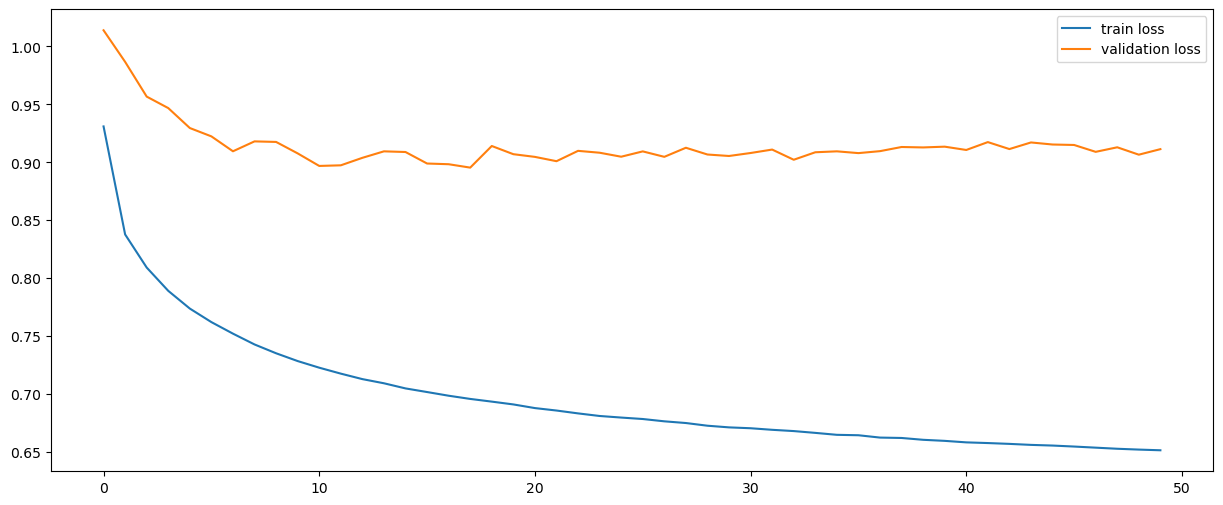

In [33]:
plt.figure(figsize=(15,6))
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='validation loss')
plt.legend()

## Model_Testing

In [23]:
model = torch.load('/Users/jandh/Desktop/Old Desktop/od/1 quater/Project Lab/best_val_model_pytorch')

n_correct = 0.
n_total = 0.
for inputs, targets in test_loader:
    # Move to GPU
    inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)

    # Forward pass
    outputs = model(inputs)
    
    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)

    # update counts
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

test_acc = n_correct / n_total
print(f"Test acc: {test_acc:.4f}")

/var/folders/vf/gw1t6f4j3mv84kp8kpw4j_bw0000gn/T/ipykernel_2491/1323947167.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('/Users/jandh/Desktop/Old D

Test acc: 0.7334


In [24]:
all_targets = []
all_predictions = []

for inputs, targets in test_loader:
    # Move to GPU
    inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)

    # Forward pass
    outputs = model(inputs)
    
    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)

    all_targets.append(targets.cpu().numpy())
    all_predictions.append(predictions.cpu().numpy())

all_targets = np.concatenate(all_targets)    
all_predictions = np.concatenate(all_predictions)   

In [27]:
print('accuracy_score:', accuracy_score(all_targets, all_predictions))
print(classification_report(all_targets, all_predictions, digits=4))

accuracy_score: 0.7334369026384601
              precision    recall  f1-score   support

           0     0.6764    0.7627    0.7170     51924
           1     0.8279    0.7104    0.7647     53532
           2     0.7142    0.7278    0.7209     50961

    accuracy                         0.7334    156417
   macro avg     0.7395    0.7336    0.7342    156417
weighted avg     0.7406    0.7334    0.7346    156417

